### 1. Decompress input data

In [ ]:
%%bash
unzip catdog_data.zip

### 2. Examine input images

In [12]:
%%bash
ls catdog_data/

test
train
validation


In [13]:
%%bash
ls catdog_data/train/*/*|wc -l
ls catdog_data/train/cats/*|wc -l
ls catdog_data/train/dogs/*|wc -l
ls catdog_data/test/*/*|wc -l
ls catdog_data/validation/*/*|wc -l

    2000
    1000
    1000
     400
     600


In [14]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import *
import utils
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from matplotlib.image import imread
from keras.models import Sequential
from keras.layers import *
import typing
import cv2

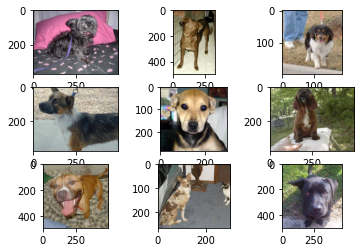

In [2]:
# plot dog photos from the dogs vs cats dataset
# define location of dataset
folder = 'catdog_data/train/dogs/'
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(3, 3, i+1)
    # define filename
    filename = f"{folder}dog.{str(i)}.jpg"
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

### 4. Pre-process and augment input images
Tutorial here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

In [180]:
#Specifying the image
Image_Width=224
Image_Height=224
Batch_Size = 32
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [264]:
# randomly rotate the train images
train_generator = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=45, fill_mode='nearest', 
    brightness_range = (0.8, 1.25),
    zoom_range= (0.8, 1.25),
    width_shift_range=0.2, height_shift_range=0.2,
    channel_shift_range=50
)
train_img_flow = train_generator.flow_from_directory(batch_size=Batch_Size, directory="catdog_data/train", target_size=Image_Size, class_mode="binary")

# non-augmented original image data generators
original_generator = ImageDataGenerator(rescale=1./255)
test_img_flow = original_generator.flow_from_directory(batch_size=Batch_Size, directory="catdog_data/test", target_size=Image_Size, class_mode="binary")
val_img_flow = original_generator.flow_from_directory(batch_size=Batch_Size, directory="catdog_data/validation/", target_size=Image_Size, class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


### 5. Create a 4-layer CNN model

In [265]:
def create_CNN_Model(Image_size: tuple, Image_channels=3) -> keras.models.Sequential:
    assert len(Image_Size)==2 and Image_Size[0]>0 and Image_Size[1]>0, "Image_size must be a tuple of two positive integers!"
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer=keras.initializers.he_uniform(seed=42),input_shape=(Image_Width,Image_Height,Image_Channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3),kernel_initializer=keras.initializers.he_uniform(seed=42),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),kernel_initializer=keras.initializers.he_uniform(seed=42),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),kernel_initializer=keras.initializers.he_uniform(seed=42),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512,activation='relu', kernel_regularizer=keras.regularizers.L2(1e-2)))
    model.add(Dense(1,activation='sigmoid'))
    return model

model = create_CNN_Model(Image_size=Image_Size)
model.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_216 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_204 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_217 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_205 (MaxPooli  (None, 54, 54, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_218 (Conv2D)         (None, 52, 52, 128)       73856     
                                                                 
 batch_normalization_170 (Ba  (None, 52, 52, 128)    

In [266]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [267]:
def fitted_model(model: Sequential, lr: float, train_imgs: keras.preprocessing.image.DirectoryIterator, val_imgs: keras.preprocessing.image.DirectoryIterator) -> typing.Tuple:
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights.best.inc.blond.hdf5', verbose=1, save_best_only=True)
    model_history = model.fit(train_imgs, 
                            validation_data=val_imgs,
                            steps_per_epoch=len(train_imgs),
                            validation_steps=len(val_imgs),
                            epochs=150, callbacks=[checkpointer])
    return (model, model_history)

### 5. Train the augmented dataset, thus saving, loading the model and test the accuracy using the test data set

In [269]:
training_history: typing.List[tf.keras.callbacks.History] = []

# first 50% epochs: 1e-3, 50%-80% epochs: 1e-4, 80%-100% epochs: 1e-5 
def obtain_lr(initial_lr: float, total_epochs: int, epoch_index: int) -> float:
    assert total_epochs>=10 and total_epochs%10==0, "The number of epochs must be divsible by 10!"
    assert 0<=epoch_index<total_epochs, "The index of an epoch 'i' must suffice 0<=i<total_epochs!"
    return initial_lr if (epoch_index+1)<=total_epochs/2 else initial_lr/10 if (epoch_index+1)<=total_epochs*0.8 else initial_lr/100

for i, img_flow in enumerate(train_img_flow):
    model, history = fitted_model(model, obtain_lr(1e-3, 150, i), train_img_flow, val_img_flow)
    training_history.append(history)
    model.save("dog_cat_adam_aug_CNN.h5")

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.8671 - accuracy: 0.6725
Epoch 1: val_loss improved from inf to 1.31689, saving model to weights.best.inc.blond.hdf5
63/63 [==============================] - 35s 415ms/step - loss: 0.8671 - accuracy: 0.6725 - val_loss: 1.3169 - val_accuracy: 0.5950
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 1.3164 - accuracy: 0.7000
Epoch 2: val_loss did not improve from 1.31689
63/63 [==============================] - 23s 359ms/step - loss: 1.3164 - accuracy: 0.7000 - val_loss: 1.5256 - val_accuracy: 0.5667
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 1.0240 - accuracy: 0.7000
Epoch 3: val_loss improved from 1.31689 to 1.10275, saving model to weights.best.inc.blond.hdf5
63/63 [==============================] - 21s 334ms/step - loss: 1.0240 - accuracy: 0.7000 - val_loss: 1.1027 - val_accuracy: 0.5633
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 0.8705 - accura

In [ ]:
%%bash
# grep validation accuracy using Perl-style regex
grep val_accuracy Project1.1.ipynb|gsed -r 's/\\n",$//'|ggrep -Po "(?<=val_accuracy:\s).+" # MacOS-specific
# Linux-specific version:
#grep val_accuracy Project1.1.ipynb|sed -r 's/\\n",$//'|grep -Po "(?<=val_accuracy:\s).+"

0.5000
0.5000
0.5000
0.5000
0.5000
0.5250
0.5250
0.5450
0.6150
0.5767
0.5833
0.6117
0.5917
0.6400
0.6767
0.6783
0.6817
0.6500
0.6700
0.7033
0.7117
0.7000
0.6933
0.7117
0.6617
0.7067
0.6817
0.6617
0.6283
0.7217
0.7317
0.7167
0.7183
0.6933
0.7100
0.7050
0.7150
0.7317
0.6667
0.7133
0.7183
0.7317
0.7133
0.7217
0.7317
0.7100
0.7183
0.7533
0.6700
0.7017
0.7133
0.7117
0.7250
0.7083
0.7133
0.7233
0.7067
0.7150
0.7167
0.6750
0.7483
0.7317
0.7467
0.7433
0.7350
0.6700
0.7367
0.6733
0.6633
0.7117
0.7267
0.7183
0.7033
0.7217
0.7733
0.6467
0.6833
0.7117
0.7433
0.6933
0.6683
0.7317
0.6450
0.7183
0.7067
0.7050
0.7467
0.7350
0.7383
0.7633
0.7667
0.7417
0.7567
0.7533
0.7433
0.7117
0.6750
0.7167
0.6950


### 6. Export the training and validation history into a json file via <code>json.dumps</code>

In [ ]:
from json import dumps # takes a n object and returns to a string

with open("CNN_training_history.json", "w") as f:
    f.write(dumps([el.history for el in training_history]))

### 7. Evaluate the accuracy of the trained model after 80 randomly shuffled epochs (5*2 epochs for each augmented data flow)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("dog_cat_adam_aug_CNN.h5")
acc = model.evaluate(test_img_flow, verbose=0)[1]
print(round(acc, 4)*100)

76.0
